In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# LOCAL
# DATA_PATH = '/Users/ivan_zorin/Documents/DEV/data/mnist'
# LOG_PATH = '/Users/ivan_zorin/Documents/DEV/runs/ntl/mnist'


# ZHORES
DATA_PATH = '/trinity/home/ivan.zorin/dev/data/'
PROJECT_PATH = '/trinity/home/ivan.zorin/dev/code/ntl/'
LOG_PATH = '/beegfs/home/ivan.zorin/dev/logs/mnist'


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import seaborn as sns

import torch 
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter

import sys
sys.path.append(PROJECT_PATH)
from ntl.utils import get_date

In [4]:
mnist_data = MNIST(DATA_PATH, train=True, download=True, transform=ToTensor())

In [5]:
# params 
anomal_class = 5

device = 'cuda' if torch.cuda.is_available() else 'cpu'
batch_size = 64
lr = 0.001
triplet_loss_weight = 0.5
is_contrastive = True
n_epochs = 50

In [6]:
# select any class to be anomalous data
anomal_idxs = np.where(mnist_data.targets == anomal_class)[0]
# get idxs of anomalous samples
normal_idxs = set(np.arange(len(mnist_data))) - set(anomal_idxs)
normal_idxs = np.array(list(normal_idxs))
# split dataset into: 
#  - normal_train - normal samples for training
#  - anomal_test, normal_test = test_data - both normal and anomalous samples
#  - anomal_exposed - anomalous samples seen by a model during train
normal_mnist = data.Subset(mnist_data, normal_idxs)
anomal_mnist = data.Subset(mnist_data, anomal_idxs) 
normal_train, normal_test = data.random_split(normal_mnist, [normal_idxs.shape[0] - anomal_idxs.shape[0], anomal_idxs.shape[0]]) # NOTE 

num_exposed_outliers = 8
anomal_test, anomal_exposed = data.random_split(anomal_mnist, [len(anomal_mnist) - num_exposed_outliers, num_exposed_outliers]) # NOTE
test_data = data.ConcatDataset([normal_test, anomal_test]) # NOTE

In [7]:
class DummyModel(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim
        self.linear = nn.Linear(emb_dim, emb_dim)
        self.layer = nn.Identity()
        
    def forward(self, x):
        bs = x.shape[0]
        emb = torch.rand(bs, self.emb_dim).to(x.device)
        return emb, x
    
    
    
class AEModel(nn.Module):
    def __init__(self, bias=True):
        super().__init__()
        self.bias = bias
        channels = [1, 4, 16, 32, 64]
        strides = [2, 2, 1, 1]
        layers = []
        for i in range(len(channels) - 1):

            layers += [
                nn.Conv2d(in_channels=channels[i], out_channels=channels[i+1], stride=strides[i], kernel_size=3, padding=0, bias=bias),
                nn.BatchNorm2d(num_features=channels[i+1]),
                nn.Dropout(0.15),
                nn.ReLU(),
                # nn.MaxPool2d(kernel_size=2, padding=1)
            ]
            
        # layers += [nn.Flatten()]    
        self.encoder = nn.Sequential(*layers)
        
        channels.reverse()
        strides.reverse()
        output_paddings = [0, 0, 0, 1]
        layers = []
        for i in range(len(channels) - 1):

            layers += [
                nn.ConvTranspose2d(in_channels=channels[i], out_channels=channels[i+1], stride=strides[i], kernel_size=3, padding=0, bias=bias, output_padding=output_paddings[i]),
                nn.BatchNorm2d(num_features=channels[i+1]),
                nn.Dropout(0.15),
                nn.ReLU()
            ]
            
        self.decoder = nn.Sequential(*layers)
            
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, emb):
        return self.decoder(emb)
        
    def forward(self, x):
        emb = self.encoder(x)
        x = self.decoder(emb)
        emb = emb.reshape(emb.shape[0], -1)
        
        return emb, x


In [8]:
####################IS NOT USED################################################
class ContrastiveLoss(nn.Module):
    def __init__(self, eps=0.1):
        super().__init__()
        self.eps = eps
        
    def prepare_terms(self, embeddings, negatives):
        bs = embeddings.shape[0]
        anchors, positives = embeddings[:bs//2], embeddings[bs//2:]
        if negatives.shape[0] < bs // 2:
            tile_shape = [int(np.ceil((bs // 2) / negatives.shape[0]))] + [1] * (len(negatives.shape) - 1)
            negatives = negatives.tile(*tile_shape)[:bs // 2]    
            perm_idxs = torch.randperm(negatives.shape[0])
            negatives = negatives[perm_idxs]
        else:
            perm_idxs = torch.randperm(negatives.shape[0])
            negatives = negatives[perm_idxs]
            negatives = negatives[:bs // 2]
            
        return anchors, positives, negatives
    
    def forward(self, embeddings, negatives):
        anchors, positives, negatives = self.prepare_terms(embeddings, negatives)
    
        # compute loss
        loss = torch.norm(anchors - positives, 2)
#######################################################################


def prepare_terms(embeddings, negatives):
    """
    prepare anchor, positive and negative terms of triplet loss
    """
    bs = embeddings.shape[0]
    anchors, positives = embeddings[:bs//2], embeddings[bs//2:]
    if negatives.shape[0] < bs // 2:
        tile_shape = [int(np.ceil((bs // 2) / negatives.shape[0]))] + [1] * (len(negatives.shape) - 1)
        negatives = negatives.tile(*tile_shape)[:bs // 2]    
        perm_idxs = torch.randperm(negatives.shape[0])
        negatives = negatives[perm_idxs]
    else:
        perm_idxs = torch.randperm(negatives.shape[0])
        negatives = negatives[perm_idxs]
        negatives = negatives[:bs // 2]
        
    return anchors, positives, negatives


def vis_of_random_sample(model, loader, device):
    """
    returns random sample from the loader and its prediction by the model
    """
    idx = np.random.choice(len(loader.dataset))
    x, target = loader.dataset[idx]
    _, x_hat = model(x[None].to(device))
    x_hat = x_hat.detach().cpu().squeeze(0)
    
    return x, x_hat


def tsne_of_embeddings(embs, targets, names, title=''):
    """
    visualizes the embeddings with tSNE
    """
    sizes = [emb.shape[0] for emb in embs]
    new_targets = []
    new_targets.append(np.zeros(sizes[0])) # normal
    new_targets.append(np.ones(sizes[1])) # anomal
    new_targets.append(np.ones(sizes[2])) # exposed
    
    embs_stacked = np.concatenate(embs)
    
    embs2d = TSNE(2).fit_transform(embs_stacked)
    fig = plt.figure()
    plt.scatter(embs2d[:sizes[0], 0], embs2d[:sizes[0], 1], color='b', marker='.', label=names[0], alpha=0.5)
    # test normal
    plt.scatter(embs2d[sizes[0]:sizes[0] + sizes[1], 0], embs2d[sizes[0]:sizes[0] + sizes[1], 1], color='g', marker='1', label=names[1], alpha=0.5)
    # test anomal
    plt.scatter(embs2d[-sizes[2]:-1, 0], embs2d[-sizes[2]:-1, 1], color='r', marker='x', label=names[2], alpha=1)
    plt.legend()
    plt.title(title)
    # plt.show()
        
    return fig

# fig, embs2d = tsne_of_embeddings(embs, targets, ['normal', 'anomal', 'exposed'])


In [9]:
# loaders: train, test_normal, test_anomalous, exposed
train_loader = data.DataLoader(normal_train, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=batch_size)
test_normal_loader = data.DataLoader(normal_test, batch_size=batch_size, shuffle=False)
test_anomal_loader = data.DataLoader(anomal_test, batch_size=batch_size, shuffle=False)
exposed_loader = data.DataLoader(anomal_exposed, batch_size=len(anomal_exposed))

# model
model = AEModel().to(device)

# optimizer
optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

# loss
rec_loss_fn = nn.MSELoss(reduction='none')
triplet_loss_fn = nn.TripletMarginLoss(reduction='none')



In [59]:
def train(logger, epoch):
    model.train()
    # t = tqdm(train_loader, leave=False, )
    # t.set_description('train')
    t = train_loader
    for i, batch in enumerate(t):
        optim.zero_grad()
        
        x, target = batch
        x = x.to(device)
        emb, x_hat = model(x)
        # LOSS
        # reconstruction loss
        rec_loss = rec_loss_fn(x, x_hat)
        rec_loss = rec_loss.mean(list(range(1, len(rec_loss.shape))))
        # contrastive loss
        if is_contrastive:
            outliers, _ = next(iter(exposed_loader))
            # outliers = outliers
            neg, _ = model(outliers.to(device))
            anchor, pos, neg = prepare_terms(emb, neg)
            contrastive_loss = triplet_loss_fn(anchor, pos, neg)
        else:
            contrastive_loss = 0
        # total loss
        rec_loss = rec_loss.mean()
        contrastive_loss = contrastive_loss.mean()
        loss = rec_loss + triplet_loss_weight * contrastive_loss
        loss.backward()
        optim.step()
        
        step = epoch * len(t) + i
        logger.add_scalar('train/rec_loss', rec_loss.item(), step)
        logger.add_scalar('train/contrastive_loss', contrastive_loss.item(), step)
        logger.add_scalar('train/loss', loss.item(), step)
    
    
def validate_on_loader(loader, model, device, loader_name=''):
    embeddings = []
    losses = []
    targets = []
    # t = tqdm(loader, leave=False)
    # t.set_description(loader_name)
    t = loader
    for i, batch in enumerate(t):
        with torch.no_grad():
            x, target = batch
            x = x.to(device)
            emb, x_hat = model(x)
            loss = F.mse_loss(x, x_hat, reduction='none')
            loss = loss.mean(list(range(1, len(loss.shape)))).detach().cpu().numpy()
            
            losses.append(loss)
            embeddings.append(emb.detach().cpu().numpy())
            targets.append(target.cpu().numpy())

    losses = np.concatenate(losses)
    embeddings = np.concatenate(embeddings)
    targets = np.concatenate(targets)
            
    return losses, embeddings, targets
    
    
def validate(logger, epoch):
    model.eval()
    
    # def validate_on_loader(loader, loader_name=''):
    #     embeddings = []
    #     losses = []
    #     targets = []
    #     # t = tqdm(loader, leave=False)
    #     # t.set_description(loader_name)
    #     t = loader
    #     for i, batch in enumerate(t):
    #         with torch.no_grad():
    #             x, target = batch
    #             x = x.to(device)
    #             emb, x_hat = model(x)
    #             loss = F.mse_loss(x, x_hat, reduction='none')
    #             loss = loss.mean(list(range(1, len(loss.shape)))).detach().cpu().numpy()
                
    #             losses.append(loss)
    #             embeddings.append(emb.detach().cpu().numpy())
    #             targets.append(target.cpu().numpy())

    #     losses = np.concatenate(losses)
    #     embeddings = np.concatenate(embeddings)
    #     targets = np.concatenate(targets)
                
    #     return losses, embeddings, targets
    
    embeddings = []
    losses = []
    
    normal_loss, normal_emb, normal_targets = validate_on_loader(test_normal_loader, model, device, 'normal')
    anomal_loss, anomal_emb, anomal_targets = validate_on_loader(test_anomal_loader, model, device, 'anomalous')
    exposed_loss, exposed_emb, exposed_targets = validate_on_loader(exposed_loader, model, device, 'exposed')
    
    # log embeddings
    embeddings = np.concatenate([normal_emb, anomal_emb, exposed_emb])
    # new_targets = np.concatenate([np.zeros[normal_emb.shape[0], np.ones(anomal_emb.shape[0])], 2 * np.ones(exposed_emb.shape[0])])
    labels = ['normal'] * normal_emb.shape[0] + ['anomal'] * anomal_emb.shape[0] + ['exposed'] * exposed_emb.shape[0]
    
    logger.add_embedding(embeddings, labels, global_step=epoch)
    
    # plot embeddings, visualizing slices
    fig = tsne_of_embeddings([normal_emb, anomal_emb, exposed_emb], [normal_targets, anomal_targets, exposed_targets], names=['normal', 'anomal', 'exposed'])
    logger.add_figure('embeddings/tsne', fig, epoch)
    
    
    # visualization of reconstruction of random NORMAL sample
    x, x_hat = vis_of_random_sample(model, test_normal_loader, device)
    logger.add_image('normal/origin', x, epoch)
    logger.add_image('normal/reconstructed', x_hat, epoch)
    
    # EXPOSED sample
    x, x_hat = vis_of_random_sample(model, exposed_loader, device)
    logger.add_image('exposed/origin', x, epoch)
    logger.add_image('exposed/reconstructed', x_hat, epoch)
    
    # return [normal_emb, anomal_emb, exposed_emb], [normal_targets, anomal_targets, exposed_targets]

In [17]:
_dir = os.path.join(LOG_PATH, get_date())
print(f'run is at {_dir}')
logger = SummaryWriter(_dir)
n_epochs = 50
t = tqdm(range(5))
for epoch in t:
    t.set_description(f'epoch {epoch}')
    train(logger, epoch)
    validate(logger, epoch)
    
    

run is at /beegfs/home/ivan.zorin/dev/logs/mnist/23_10_23_15_19


  0%|          | 0/5 [00:00<?, ?it/s]

In [63]:
model_triplet = torch.load('/beegfs/home/ivan.zorin/dev/logs/mnist/triplet/23_10_23_17_03/model.ckpt')
model_notriplet = torch.load('/beegfs/home/ivan.zorin/dev/logs/mnist/no_triplet/23_10_23_17_06/model.ckpt')
model_triplet_weighting = torch.load('/beegfs/home/ivan.zorin/dev/logs/mnist/triplet_weight_schedule/23_10_24_14_22/model.ckpt')

In [14]:
from ntl.utils import fit_and_test_gmm, plot_roc_auc
from collections import defaultdict

In [64]:
def supervised_validation(model, train_loader, normal_loader, anomal_loader, device):
    embeddings = []
    losses = []
    
    train_losses, train_embeddings, _ = validate_on_loader(train_loader, model, device, 'train')
    train_labels = np.zeros(train_losses.shape[0])

    normal_losses, normal_embeddings, _ = validate_on_loader(normal_loader, model, device, 'normal')
    normal_labels = np.zeros(normal_losses.shape[0])
    
    anomal_losses, anomal_embeddings, _ = validate_on_loader(anomal_loader, model, device, 'anomal')
    anomal_labels = np.ones(anomal_losses.shape[0])
    
    test_losses = np.concatenate([normal_losses, anomal_losses])
    test_embeddings = np.concatenate([normal_embeddings, anomal_embeddings])
    test_labels = np.concatenate([normal_labels, anomal_labels])
    
    
    
    fit_and_test_gmm(
        train_embeddings, 
        test_embeddings,
        test_labels,
        n_components=1
    )
    
    plot_roc_auc(test_labels, test_losses)
    

no_triplet


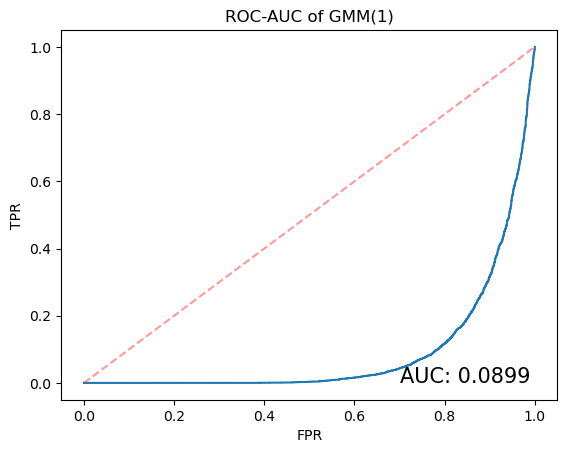

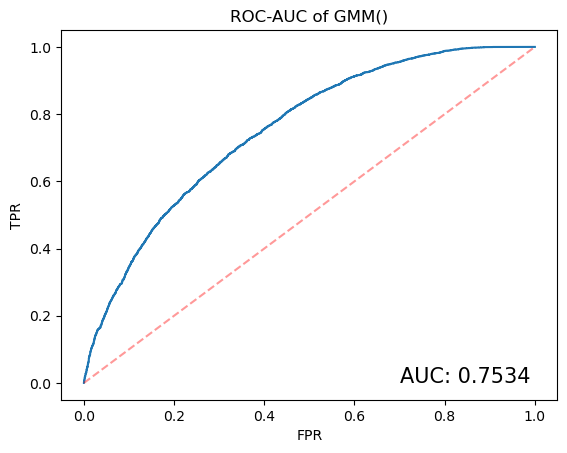

triplet


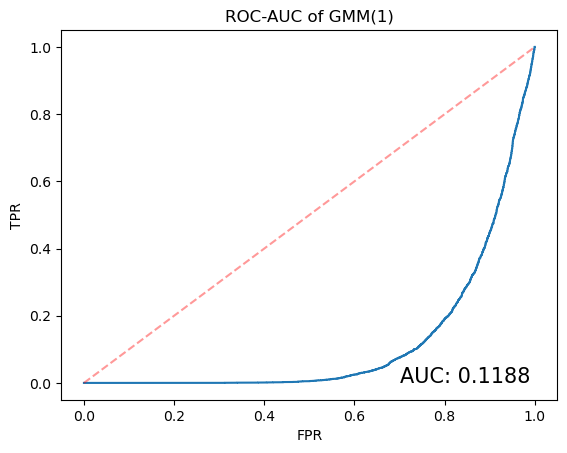

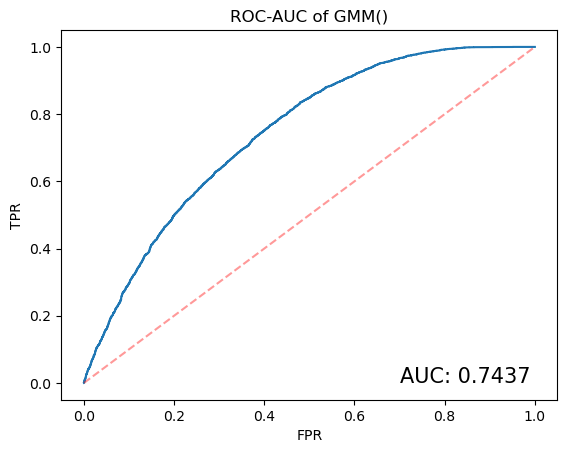

triplet_with_weighting


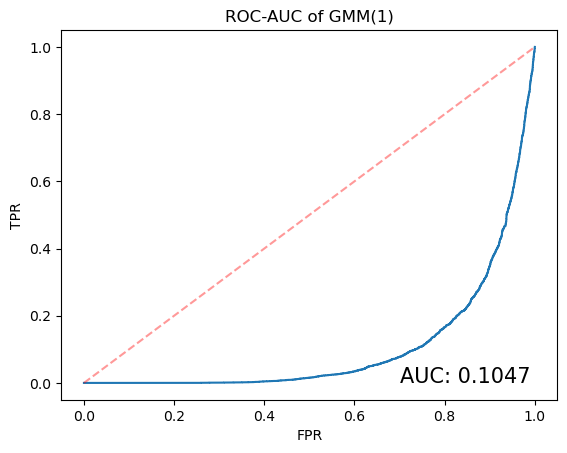

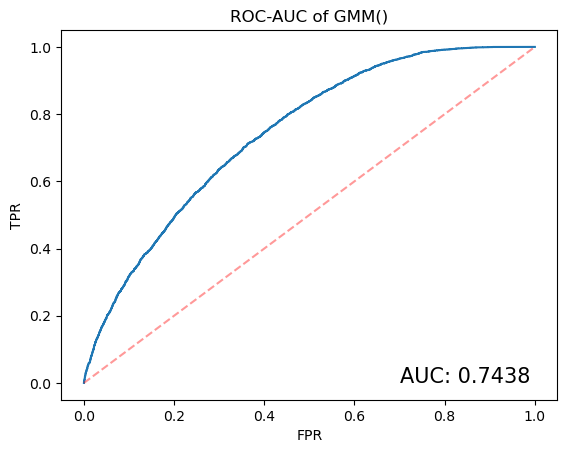

In [66]:
models = [model_notriplet, model_triplet, model_triplet_weighting]
model_names = ['no_triplet', 'triplet', 'triplet_with_weighting']

for model, name in zip(models, model_names):
    print(name)
    supervised_validation(model, train_loader, test_normal_loader, test_anomal_loader, device)
    print('=' * 50)

In [46]:
normal_emb, normal_losses = compute_embeddings(test_normal_loader)
anomal_emb, anomal_losses = compute_embeddings(test_anomal_loader)

num_normal = normal_losses['triplet'].shape[0]
num_anomal = anomal_losses['triplet'].shape[0]

labels = np.concatenate([np.zeros(num_normal), np.ones(num_anomal)])

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

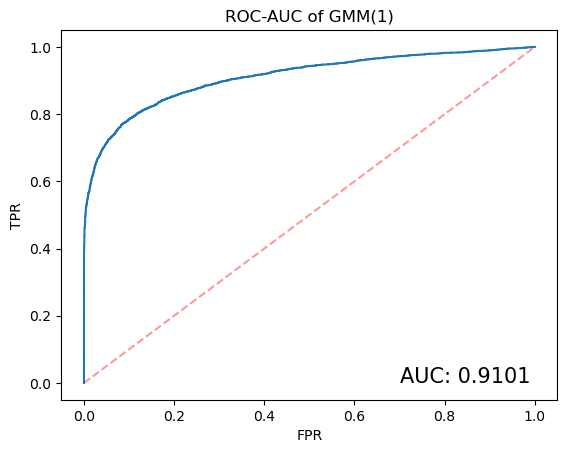

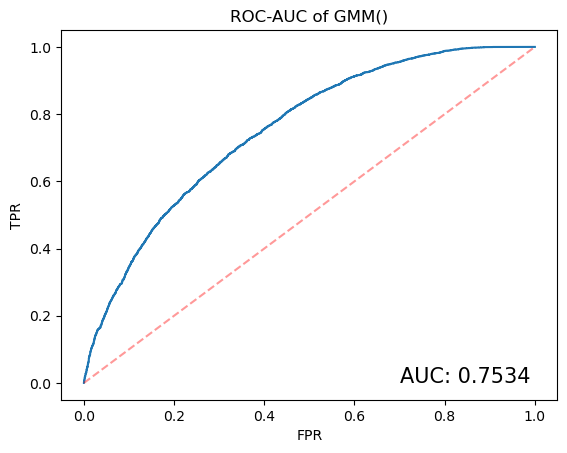

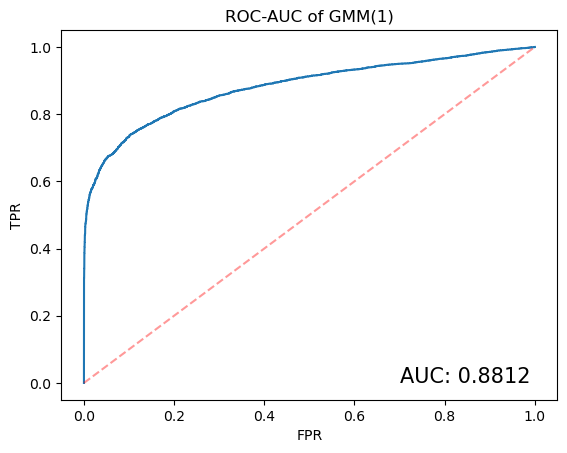

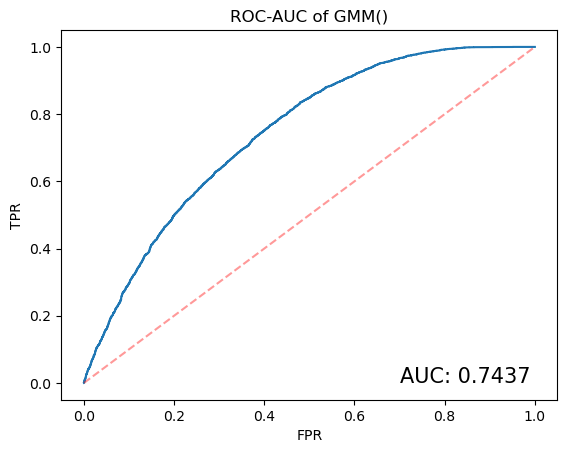

In [58]:
# no_triplet
fit_and_test_gmm(
    train_emb['notriplet'], 
    np.concatenate([normal_emb['notriplet'], anomal_emb['notriplet']]),
    1-labels,
    n_components=1
)
plot_roc_auc(labels,
              np.concatenate([normal_losses['notriplet'], anomal_losses['notriplet']]))

print('=' * 100)

# triplet 
fit_and_test_gmm(
    train_emb['triplet'], 
    np.concatenate([normal_emb['triplet'], anomal_emb['triplet']]),
    1-labels,
    n_components=1
)
plot_roc_auc(labels,
              np.concatenate([normal_losses['triplet'], anomal_losses['triplet']]))